In [3]:
import os
from pathlib import Path
from tqdm.auto import tqdm # show progress bars

In [4]:
import tensorflow as tf
from tensorflow import keras
import keras_cv

from keras_cv import bounding_box
from keras_cv import visualization

Using TensorFlow backend


In [5]:
# Hyperparameters
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0

In [6]:
bounding_box_format = "center_xywh"

In [7]:
# Creating a dictionary for the classes
class_ids = [
    'biker',
    'car',
    'pedestrian',
    'trafficLight',
    'trafficLight-Green',
    'trafficLight-GreenLeft',
    'trafficLight-Red',
    'trafficLight-RedLeft',
    'trafficLight-Yellow',
    'trafficLight-YellowLeft',
    'truck'
]

# class_ids = ["car", "person"]

class_mapping = dict(zip(range(len(class_ids)),class_ids))
class_mapping

{0: 'biker',
 1: 'car',
 2: 'pedestrian',
 3: 'trafficLight',
 4: 'trafficLight-Green',
 5: 'trafficLight-GreenLeft',
 6: 'trafficLight-Red',
 7: 'trafficLight-RedLeft',
 8: 'trafficLight-Yellow',
 9: 'trafficLight-YellowLeft',
 10: 'truck'}

In [8]:
#!curl -L "https://public.roboflow.com/ds/v1DU0phKgN?key=ymwwXOFxNf" > "../data/example_model/roboflow.zip"; unzip "../data/example_model/roboflow.zip" > "../data/example_model/; rm "../data/example_model/roboflow.zip"

In [9]:
# Path to images and annotations
path_images = "../data/example_model/export/images"
path_annot = "../data/example_model/export/labels"
# path_images = "../data/test"
# path_annot = "../data/test"

In [10]:
txt_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".txt")
    ]
)
txt_files = txt_files[:500]

In [11]:
def parse_annotation(txt_file):
    with open(txt_file) as file:
        lines = file.readlines()
        file_name = Path(file.name).stem

    image_path = os.path.join(path_images, file_name + ".JPG")
    boxes = []
    class_ids = []
    for line in lines:
        line = line.split()

        cls = float(line[0])
        class_ids.append(cls)

        x = float(line[1]) *512
        y = float(line[2]) *512
        width = float(line[3]) *512
        height = float(line[4]) *512

        boxes.append([x, y, width, height])

    return image_path, boxes, class_ids

In [12]:
image_paths = []
bbox = []
classes = []
for txt_file in txt_files:
    image_path, boxes, class_ids = parse_annotation(txt_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

In [13]:
image_paths

['../data/example_model/export/images/1478019952686311006_jpg.rf.54e2d12dbabc46be3c78995b6eaf3fee.JPG',
 '../data/example_model/export/images/1478019952686311006_jpg.rf.JLSB3LP2Q4RuGHYKqfF6.JPG',
 '../data/example_model/export/images/1478019953180167674_jpg.rf.8a816c9d7e9b423a63ed6ecd4a663e47.JPG',
 '../data/example_model/export/images/1478019953180167674_jpg.rf.azslsZnM8FLQPu3QWLTl.JPG',
 '../data/example_model/export/images/1478019953689774621_jpg.rf.2e4b7ae29c3379da1282e85cff4c1745.JPG',
 '../data/example_model/export/images/1478019953689774621_jpg.rf.UpOkvtBppZZaLfvVZ0JX.JPG',
 '../data/example_model/export/images/1478019954186238236_jpg.rf.cbpP963e2sN7rHIZMJtD.JPG',
 '../data/example_model/export/images/1478019954186238236_jpg.rf.f8ac6ad31e400d4918ff394f903bb95c.JPG',
 '../data/example_model/export/images/1478019954685370994_jpg.rf.049fda8ca86adf1e404b41955eb4aba8.JPG',
 '../data/example_model/export/images/1478019954685370994_jpg.rf.Jah8pEPis5n1x6iQCtmT.JPG',
 '../data/example_mo

In [14]:
classes[:4]

[[10.0, 1.0, 1.0, 2.0],
 [10.0, 1.0, 1.0, 2.0],
 [10.0, 1.0, 10.0, 1.0],
 [10.0, 1.0, 10.0, 1.0]]

In [15]:
bbox[:4]

[[[222.0, 250.0, 8.5, 14.5],
  [235.0, 253.0, 12.5, 13.5],
  [260.5, 254.5, 14.5, 19.5],
  [475.5, 261.5, 18.5, 112.0]],
 [[222.0, 250.02666666666667, 8.266666666666666, 14.506666666666668],
  [234.79999999999998,
   253.01333333333335,
   12.533333333333333,
   13.653333333333334],
  [260.5333333333333, 254.72000000000003, 14.4, 19.62666666666667],
  [475.46666666666664,
   261.5466666666667,
   18.666666666666668,
   111.78666666666668]],
 [[202.0, 254.0, 9.0, 15.5],
  [211.5, 257.5, 11.5, 13.0],
  [416.0, 240.0, 57.5, 43.5],
  [239.5, 260.0, 14.5, 19.5]],
 [[202.13333333333333,
   253.86666666666667,
   9.066666666666666,
   15.360000000000001],
  [211.6, 257.49333333333334, 11.466666666666667, 13.226666666666668],
  [415.8666666666667, 239.7866666666667, 57.333333333333336, 43.52],
  [239.73333333333332, 259.84000000000003, 14.4, 19.62666666666667]]]

In [17]:
# creating ragged tensors because the number of objects varies
# from image to image
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [18]:
# Splitting data
# Determine number of validation data
num_val = int(len(txt_files) * SPLIT_RATIO)

# split into train and validation
# TODO change into random split via train_test_split
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [19]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, dtype=tf.float32),
            "bounding_boxes": bounding_boxes}

In [20]:
# Image Augmentation: https://keras.io/api/keras_cv/layers/augmentation/
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(
            mode="horizontal",
            bounding_box_format=bounding_box_format),
        keras_cv.layers.RandomShear(
            x_factor=0.2,
            y_factor=0.2,
            bounding_box_format=bounding_box_format
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(0.8, 1),
            bounding_box_format=bounding_box_format,
        ),
    ]
)

In [21]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.8, 1),
    bounding_box_format=bounding_box_format,
)

In [22]:
# create training dataset
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)


In [23]:
# create validation dataset
val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [24]:
# Visualization
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

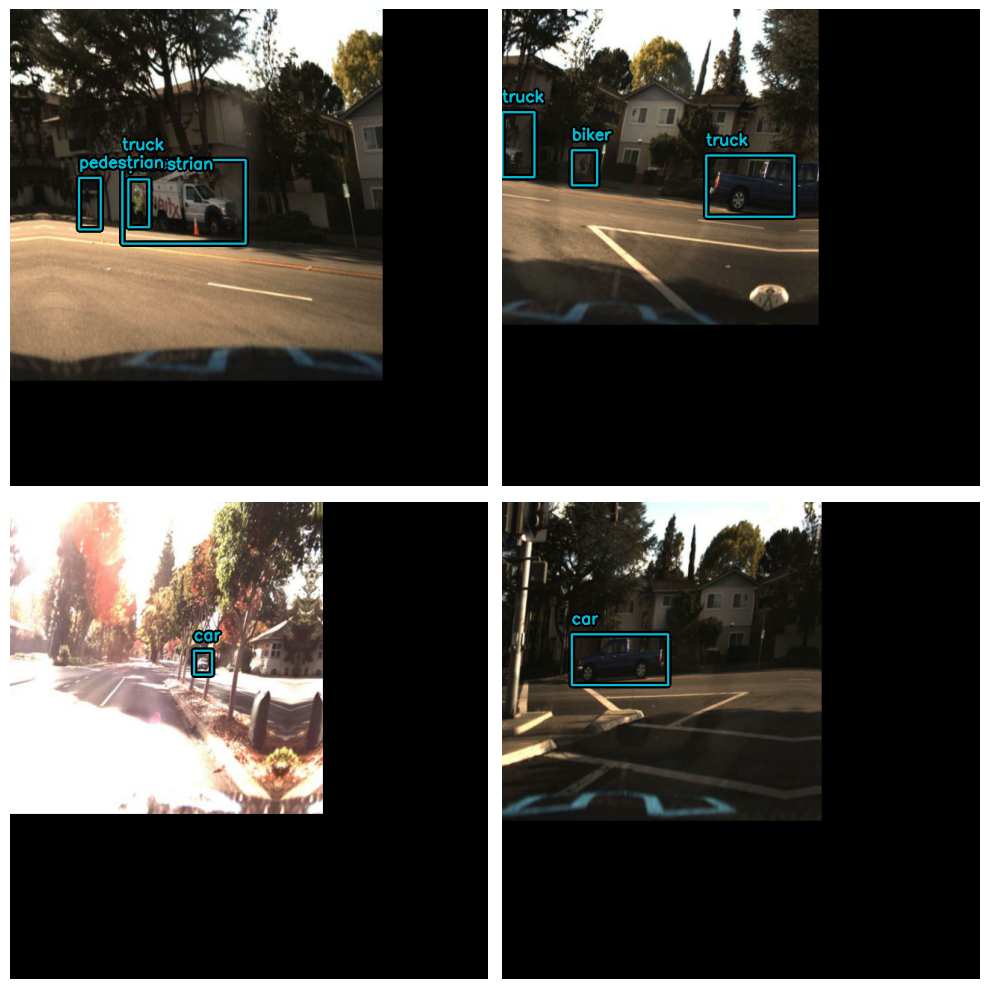

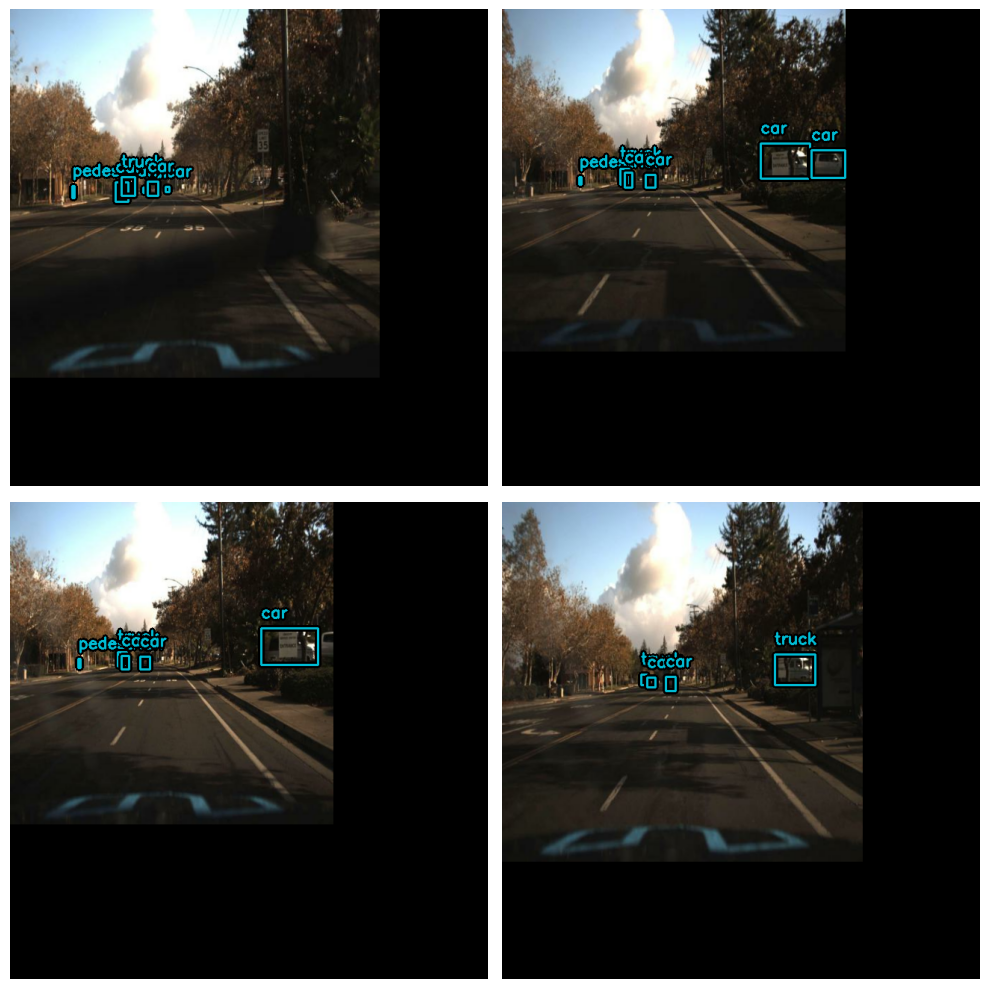

In [30]:
visualize_dataset(
    train_ds, bounding_box_format=bounding_box_format, value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format=bounding_box_format, value_range=(0, 255), rows=2, cols=2
)

In [31]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Creating the model

We can switch the backbone by using `keras_cv.models.YOLOV8Detector.from_preset` and another [preset](https://keras.io/api/keras_cv/models/tasks/yolo_v8_detector/)

In [32]:
 # We will use yolov8 small backbone with coco weights
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"
)

/Users/tim/.pyenv/versions/3.10.6/envs/kestrix/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/tim/.pyenv/versions/3.10.6/envs/kestrix/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [33]:
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.2,
    confidence_threshold=0.7,
)

The `NonMaxSuppression` layer is responsible to prune underconfident boxes. Raising the `confidence_threshold` will cause the model to only output boxes that have a higher confidence score. `iou_threshold` controls the threshold of intersection over union (IoU) that two boxes must have in order for one to be pruned out.

Next, let's build a YOLOV8 model using the `YOLOV8Detector`, which accepts a feature extractor as the `backbone` argument, a `num_classes` argument that specifies the number of object classes to detect based on the size of the `class_mapping` list, a `bounding_box_format` argument that informs the model of the format of the bbox in the dataset, and a finally, the feature pyramid network (FPN) depth is specified by the `fpn_depth` argument.

In [34]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format=bounding_box_format,
    backbone=backbone,
    fpn_depth=1,
    prediction_decoder=prediction_decoder
)

# Compilation
Loss used for YOLOV8

1. Classification Loss: This loss function calculates the discrepancy between anticipated class probabilities and actual class probabilities. In this instance, `binary_crossentropy`, a prominent solution for binary classification issues, is Utilized. We Utilized binary crossentropy since each thing that is identified is either classed as belonging to or not belonging to a certain object class (such as a person, a car, etc.).

2. Box Loss: `box_loss` is the loss function used to measure the difference between the predicted bounding boxes and the ground truth. In this case, the Complete IoU (CIoU) metric is used, which not only measures the overlap between predicted and ground truth bounding boxes but also considers the difference in aspect ratio, center distance, and box size. Together, these loss functions help optimize the model for object detection by minimizing the difference between the predicted and ground truth class probabilities and bounding boxes.

You will always want to include a global_clipnorm when training object detection models. This is to remedy exploding gradient problems that frequently occur when training object detection models.

In [35]:
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

To achieve the best results on your dataset, you'll likely want to hand craft a `PiecewiseConstantDecay` learning rate schedule.

In [36]:
yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

## COCO Metric Callback
The most popular object detection metrics are COCO metrics, which were published alongside the MSCOCO dataset. KerasCV provides an easy-to-use suite of COCO metrics under the `keras_cv.callbacks.PyCOCOCallback` symbol. Note that we use a Keras callback instead of a Keras metric to compute COCO metrics. This is because computing COCO metrics requires storing all of a model's predictions for the entire evaluation dataset in memory at once, which is impractical to do during training time.

# Train model

In [37]:
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    val_ds,
    bounding_box_format)

yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2,
    callbacks=[coco_metrics_callback],
)

Epoch 1/2
25/25 [==============================] - 42s 2s/step loss: 709.2152 - box_lo
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
Please run evaluate() first
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.9

In [51]:
new_image = load_image("../data/example_model/export/images/1478019952686311006_jpg.rf.54e2d12dbabc46be3c78995b6eaf3fee.jpg")

In [54]:
new_image_batched = tf.expand_dims(new_image, axis=0)

In [60]:
new_image_floated = tf.cast(new_image_batched, dtype=tf.float32)

In [73]:
new_image_batched

<tf.Tensor: shape=(1, 512, 512, 3), dtype=uint8, numpy=
array([[[[121, 147, 170],
         [111, 137, 160],
         [102, 128, 151],
         ...,
         [ 21,  19,  20],
         [ 39,  37,  38],
         [ 59,  57,  58]],

        [[113, 139, 162],
         [109, 135, 158],
         [106, 132, 155],
         ...,
         [ 20,  18,  19],
         [ 30,  28,  29],
         [ 41,  39,  40]],

        [[106, 132, 155],
         [108, 134, 157],
         [111, 137, 160],
         ...,
         [ 23,  19,  18],
         [ 24,  20,  21],
         [ 26,  22,  23]],

        ...,

        [[ 13,  13,  13],
         [ 14,  14,  14],
         [ 15,  15,  15],
         ...,
         [ 18,  17,  13],
         [ 18,  17,  13],
         [ 17,  16,  12]],

        [[ 13,  13,  13],
         [ 13,  13,  13],
         [ 14,  14,  14],
         ...,
         [ 18,  17,  13],
         [ 18,  17,  13],
         [ 17,  16,  12]],

        [[ 13,  13,  13],
         [ 13,  13,  13],
         [ 14,  14

In [90]:
new_data = tf.data.Dataset.from_tensor_slices((new_image_floated)).batch(1)
new_data = new_data.map(resizing)
new_data = new_data.prefetch(tf.data.AUTOTUNE)

In [82]:
tf.data.Dataset.from_tensor_slices((new_image_floated)).batch(1)

<_BatchDataset element_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None)>

In [83]:
type(new_data)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [84]:
type(val_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [91]:
next(iter(new_data.take(1)))

<tf.Tensor: shape=(1, 640, 640, 3), dtype=float32, numpy=
array([[[[119.47677 , 145.47676 , 168.47676 ],
         [108.60921 , 134.6092  , 157.6092  ],
         [103.61799 , 129.61798 , 152.61798 ],
         ...,
         [  0.      ,   0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      ]],

        [[110.95783 , 136.95784 , 159.95784 ],
         [108.36432 , 134.36432 , 157.36432 ],
         [107.95101 , 133.951   , 156.951   ],
         ...,
         [  0.      ,   0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      ]],

        [[105.81449 , 131.8145  , 154.8145  ],
         [109.220184, 135.22018 , 158.22018 ],
         [111.435776, 137.43578 , 160.43578 ],
         ...,
         [  0.      ,   0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      ]],

        ...,

        [[  0.      ,   0.      , 

In [95]:
pred = yolo.predict(new_data)

1/1 [==============================] - 1s 544ms/step


In [96]:
pred

{'boxes': array([[[-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],

In [97]:
pred.keys()

dict_keys(['boxes', 'confidence', 'classes', 'num_detections'])

# Visualize Predictions

1/1 [==============================] - 4s 4s/step


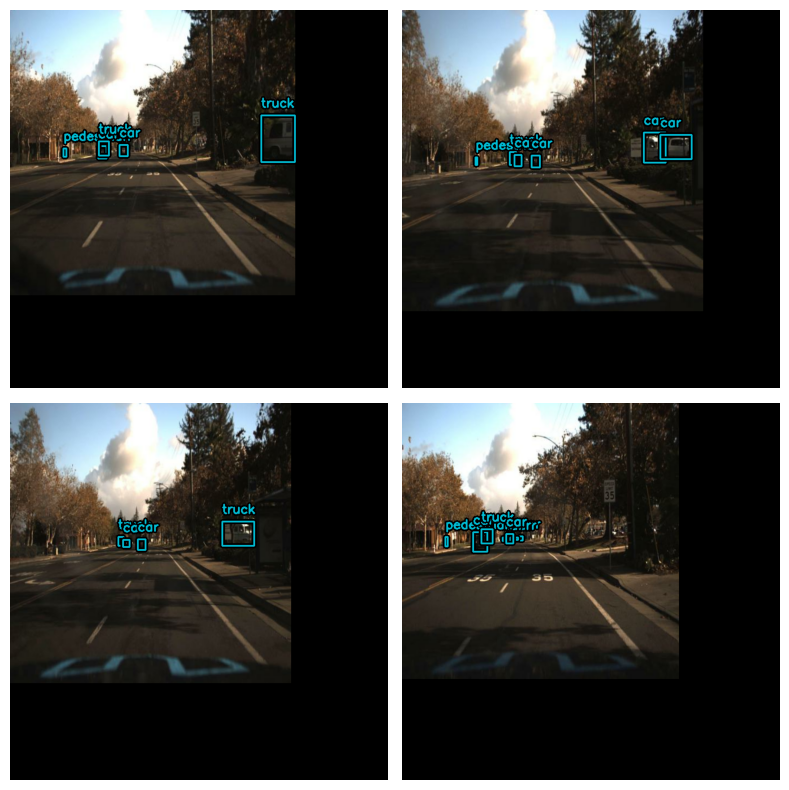

In [38]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format=bounding_box_format)

## Function to visualize a prediction

In [39]:
y_pred = pretrained_model.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format=bounding_box_format,
    class_mapping=class_mapping,
)

NameError: name 'pretrained_model' is not defined